In [36]:
# ===================================================================
# HISTORICAL HEDONIC REGRESSION FOR PROPERTY VALUATION
# Inspired by Rosen (1974)
# ===================================================================

# Step 1: Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
print("Libraries imported successfully!")


Libraries imported successfully!


In [37]:
# -------------------------------------------------------------------
# Step 2: Load Boston Housing Dataset
# -------------------------------------------------------------------
boston = fetch_openml(name='boston', version=1, parser='auto')
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['PRICE'] = boston.target
print(f"Dataset Shape: {df.shape}")
df.head()


Dataset Shape: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## **Understanding the Dataset**

The **California Housing Dataset** contains:
- **20,640 observations** (census block groups)
- **8 features** describing property and neighborhood characteristics
- **Target variable:** Median house value (in $100,000s)

**Features we're using:**
- `MedInc` - Median income of households ($10,000s)
- `HouseAge` - Median age of houses (years)
- `AveRooms` - Average number of rooms per household
- `AveBedrms` - Average number of bedrooms per household
- `Population` - Block group population

**Why these features?**
These represent the types of characteristics that were **available in 1970s property records** - physical attributes, age, and demographic data.


## **The Heterogeneity Problem**

Notice how each property differs:
- Different sizes (rooms, bedrooms)
- Different ages
- Different neighborhood income levels

**Question:** How do we compare these "apples and oranges"?

**Answer:** Hedonic pricing decomposes the total price into the value of each individual characteristic!


=== Summary Statistics ===
             CRIM          ZN       INDUS         NOX          RM         AGE  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.554695    6.284634   68.574901   
std      8.601545   23.322453    6.860353    0.115878    0.702617   28.148861   
min      0.006320    0.000000    0.460000    0.385000    3.561000    2.900000   
25%      0.082045    0.000000    5.190000    0.449000    5.885500   45.025000   
50%      0.256510    0.000000    9.690000    0.538000    6.208500   77.500000   
75%      3.677083   12.500000   18.100000    0.624000    6.623500   94.075000   
max     88.976200  100.000000   27.740000    0.871000    8.780000  100.000000   

              DIS         TAX     PTRATIO           B       LSTAT       PRICE  
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000  
mean     3.795043  408.237154   18.455534  356.674032   12.653063   22.532806  
st

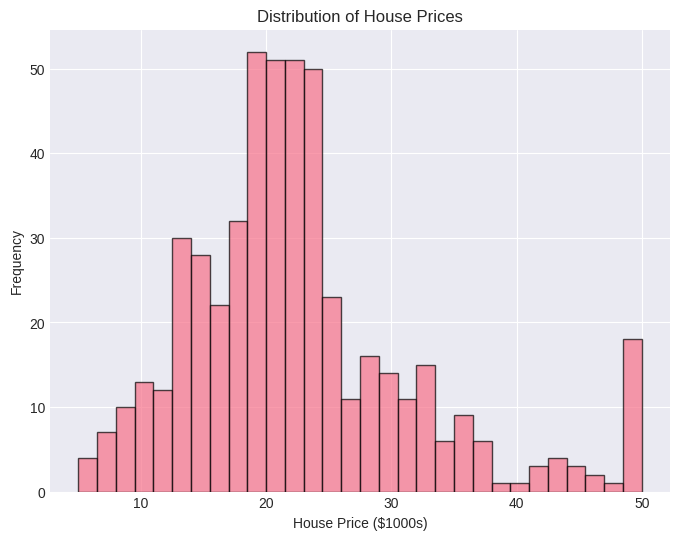

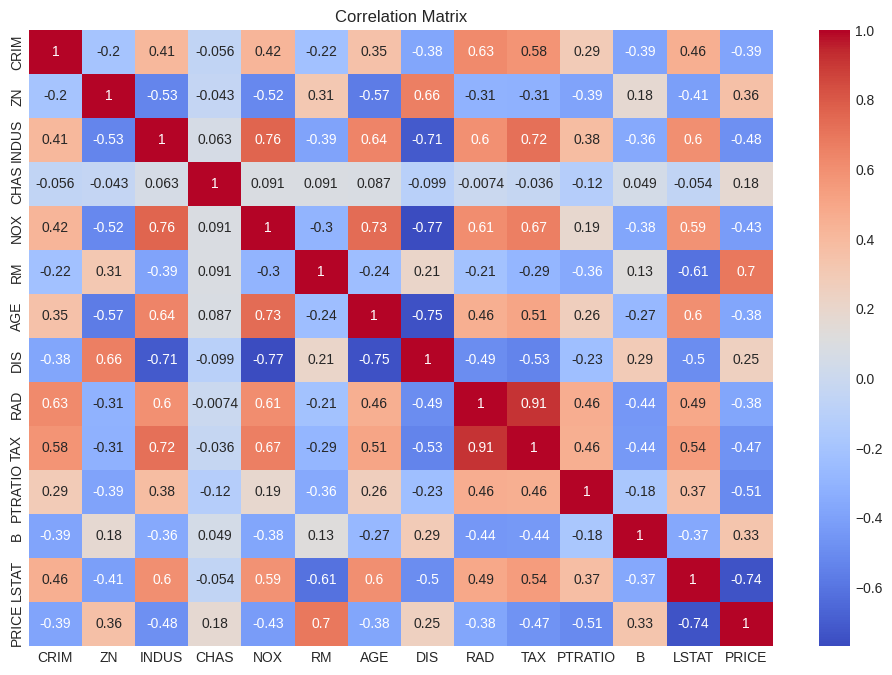

In [38]:
# -------------------------------------------------------------------
# Step 3: Exploratory Data Analysis
# -------------------------------------------------------------------
print("\n=== Summary Statistics ===")
print(df.describe())

print("\n=== Missing Values ===")
print(df.isnull().sum())

# -------------------------------------------------------------------
# Step 4: Visualize Price Distribution
# -------------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.hist(df['PRICE'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('House Price ($1000s)')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.show()

# -------------------------------------------------------------------
# Step 5: Correlation Analysis
# -------------------------------------------------------------------
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [39]:
# -------------------------------------------------------------------
# Step 6: Splitting Dataset
# -------------------------------------------------------------------
X = df.drop('PRICE', axis=1)
y = df['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 404
Testing set size: 102



## **Model Training - The 1974 Approach**

### **Method: Ordinary Least Squares (OLS)**

This is the **exact method** used by Rosen (1974) and economists in the 1970s.

**What OLS does:**
Finds the coefficients (β values) that **minimize the sum of squared errors**:
```
Minimize: Σ(Actual Price - Predicted Price)²
```

**Mathematical Solution:**
```
β̂ = (X'X)⁻¹X'y
```

This was computationally challenging in the 1970s (required mainframe computers!), but is instant today.


## **Train-Test Split Concept**

- **Training Set (80%):** Model learns the relationships between features and prices
- **Test Set (20%):** We evaluate how well the model predicts prices for properties it has never seen

This simulates real-world use: Can the model value new properties accurately?

In [40]:
# -------------------------------------------------------------------
# Step 7: Train the Hedonic Regression Model
# -------------------------------------------------------------------
model = LinearRegression()
model.fit(X_train, y_train)
print("\nHedonic Regression model trained successfully!")
print("Intercept:", round(model.intercept_, 3))


Hedonic Regression model trained successfully!
Intercept: 30.247



## **Implicit Prices - The Heart of Hedonic Analysis**

### **What Are Implicit Prices?**

Each coefficient (β) represents the **marginal willingness to pay** for one additional unit of that characteristic, holding all else constant.

**Economic Interpretation:**

If `MedInc` coefficient = 4.00, this means:
>"For every \$10,000 increase in median income of the area, the median house value increases by \$400,000 (4.00 × \$100,000)"


### **Positive vs Negative Coefficients**

- **Positive coefficient** → Feature increases property value
  - Example: More rooms → Higher price
  
- **Negative coefficient** → Feature decreases property value
  - Example: Higher pollution → Lower price


### **Why This Matters**

These implicit prices reveal:
1. **Market preferences** - What buyers value most
2. **Policy impact** - How school quality, crime, pollution affect values
3. **Investment decisions** - Which renovations add most value

In 1974, this was groundbreaking! It quantified what appraisers knew intuitively.


=== Hedonic Coefficients (Implicit Prices) ===
Feature  Coefficient
    NOX   -17.202633
     RM     4.438835
   CHAS     2.784438
    DIS    -1.447865
PTRATIO    -0.915456
  LSTAT    -0.508571
    RAD     0.262430
   CRIM    -0.113056
  INDUS     0.040381
     ZN     0.030110
      B     0.012351
    TAX    -0.010647
    AGE    -0.006296


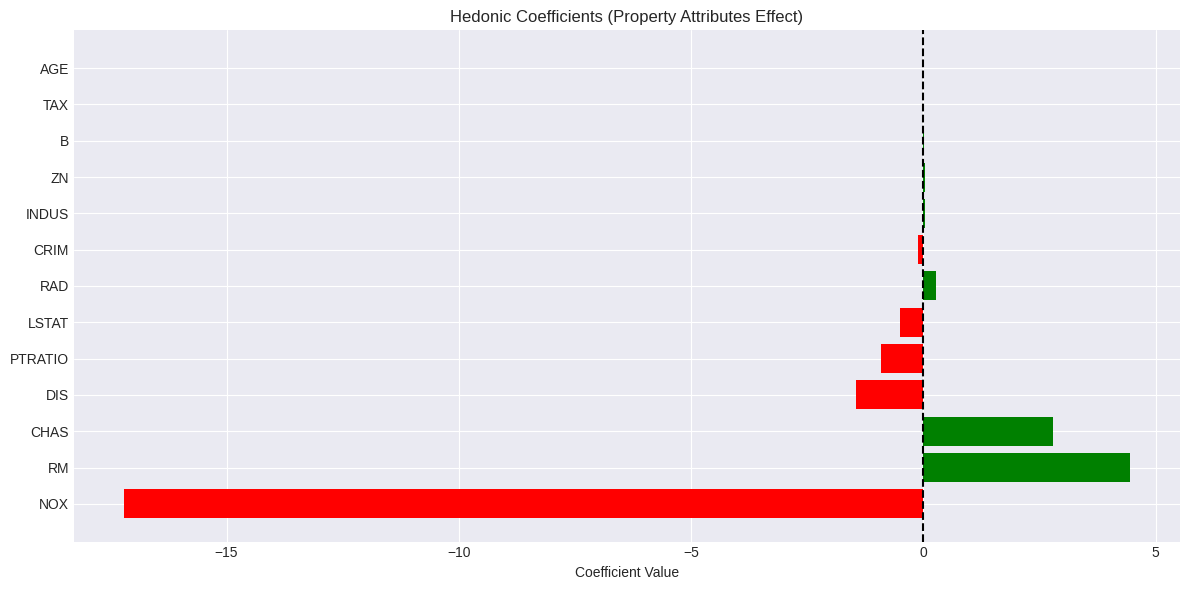

In [41]:
# -------------------------------------------------------------------
# Step 8: Analyze Model Coefficients (Implicit Prices)
# -------------------------------------------------------------------
coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\n=== Hedonic Coefficients (Implicit Prices) ===")
print(coefs[['Feature', 'Coefficient']].to_string(index=False))

# Visualize coefficient importance
plt.figure(figsize=(12,6))
colors = ['green' if c > 0 else 'red' for c in coefs['Coefficient']]
plt.barh(coefs['Feature'], coefs['Coefficient'], color=colors)
plt.title('Hedonic Coefficients (Property Attributes Effect)')
plt.xlabel('Coefficient Value')
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()




=== Model Performance ===
R²: 0.669
MAE: 3.189 ($1000s)
RMSE: 4.929 ($1000s)


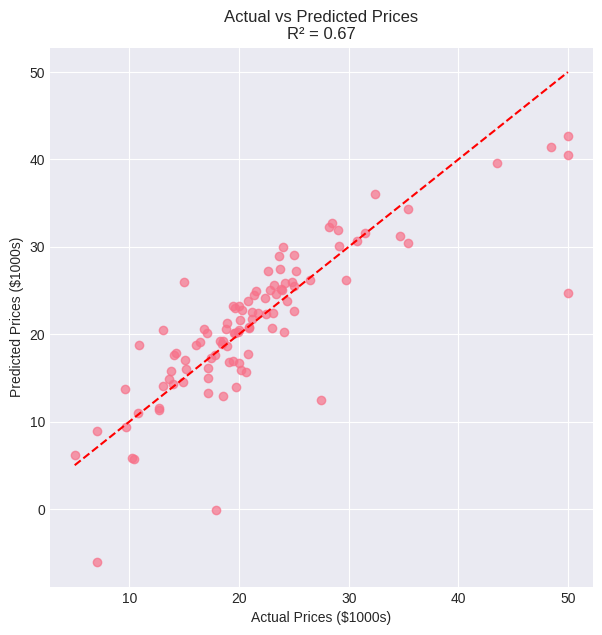

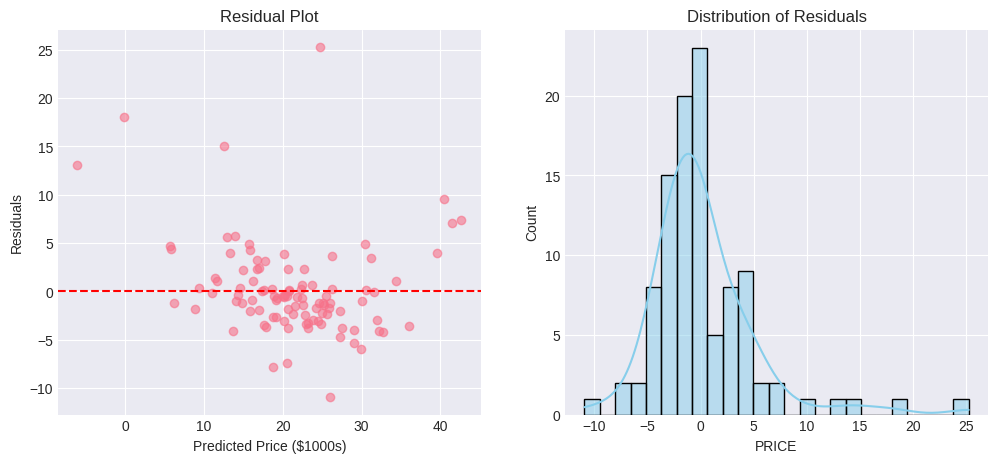


Mean Residual: 0.236
Residual Std Dev: 4.947


In [42]:
# -------------------------------------------------------------------
# Step 9: Model Evaluation
# -------------------------------------------------------------------
# Ensure X_test has numeric dtypes
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n=== Model Performance ===")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f} ($1000s)")
print(f"RMSE: {rmse:.3f} ($1000s)")

# -------------------------------------------------------------------
# Step 10: Actual vs Predicted Prices Plot
# -------------------------------------------------------------------
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Prices ($1000s)')
plt.ylabel('Predicted Prices ($1000s)')
plt.title(f'Actual vs Predicted Prices\nR² = {r2:.2f}')
plt.show()

# -------------------------------------------------------------------
# Step 11: Residual Analysis
# -------------------------------------------------------------------
residuals = y_test - y_pred
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price ($1000s)')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(1,2,2)
sns.histplot(residuals, kde=True, color='skyblue', bins=25)
plt.title('Distribution of Residuals')
plt.show()

print(f"\nMean Residual: {residuals.mean():.3f}")
print(f"Residual Std Dev: {residuals.std():.3f}")

In [43]:
# # -------------------------------------------------------------------
# # Step 12: Predict a New Property
# # -------------------------------------------------------------------
# sample_property = pd.DataFrame({
#     'CRIM': [0.05],
#     'ZN': [20.0],
#     'INDUS': [5.0],
#     'CHAS': [0],
#     'NOX': [0.45],
#     'RM': [7.0],
#     'AGE': [40.0],
#     'DIS': [5.0],
#     'RAD': [4],
#     'TAX': [300],
#     'PTRATIO': [16.0],
#     'B': [390.0],
#     'LSTAT': [8.0]
# })

# pred_price = model.predict(sample_property)[0]
# print(f"\nPredicted Price for Sample Property: ${pred_price*1000:.2f}")

STEP-BY-STEP HEDONIC REGRESSION PREDICTION METHODOLOGY
How Linear Regression Transforms Property Features into Price Predictions

STEP 1: RAW INPUT DATA (What a User Provides)

RAW PROPERTY DESCRIPTION:
--------------------------------------------------------------------------------
  Crime_Rate......................... 0.05
  Residential_Zone_pct............... 20.0
  Industrial_pct..................... 5.0
  River_Adjacent..................... No
  NOX_concentration.................. 0.45
  Avg_Rooms.......................... 7.0
  Property_Age_pct................... 40.0
  Distance_to_Employment............. 5.0
  Highway_Access_Index............... 4
  Property_Tax_per_10k............... 300
  Pupil_Teacher_Ratio................ 16.0
  Black_Population_Index............. 390.0
  Lower_Status_pct................... 8.0

Property: Suburban Family Home
Description: Well-located property with good amenities and low crime

STEP 2: DATA PREPROCESSING & TRANSFORMATION

Philosophy: Hedonic

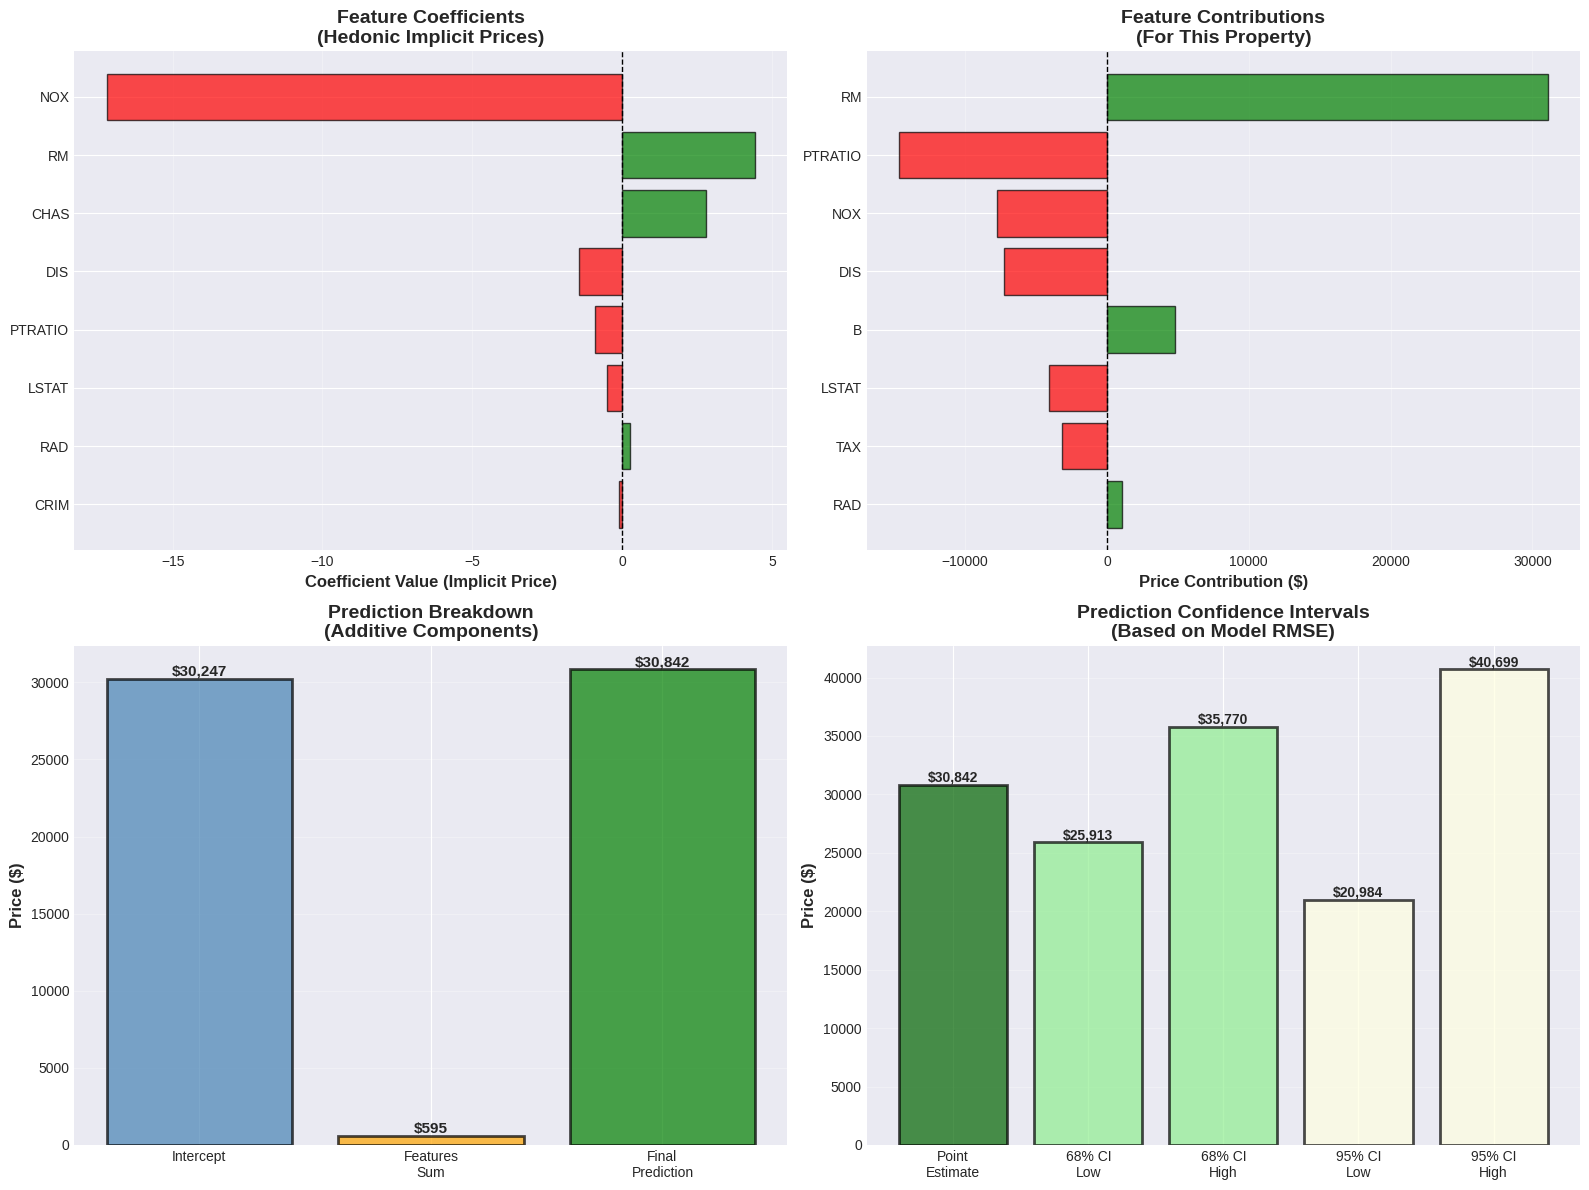


Visualization saved: 'hedonic_regression_prediction_methodology.png'

HEDONIC REGRESSION METHODOLOGY SUMMARY

PIPELINE OVERVIEW:
--------------------------------------------------------------------------------
  Step 1: Raw Input          → Property characteristics
  Step 2: Preprocessing      → Convert to numerical features (13 features)
  Step 3: Model Architecture → Linear regression with interpretable coefficients
  Step 4: Coefficient Analysis → Identify implicit prices for each feature
  Step 5: Calculation        → Weighted sum of all features
  Step 6: Prediction         → Generate final price estimate
  Step 7: Performance        → Assess model accuracy and confidence
  Step 8: Sensitivity        → Analyze feature impacts on price

FINAL RESULT:
--------------------------------------------------------------------------------
  Property Type:            Suburban Family Home
  Key Features:             7 rooms, Low crime (0.05), Good location
  Predicted Value:          $30,841

In [44]:
# ============================================================================
# STEP-BY-STEP PREDICTION METHODOLOGY DEMONSTRATION
# "Behind the Scenes: How Hedonic Regression Predicts House Prices"
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("STEP-BY-STEP HEDONIC REGRESSION PREDICTION METHODOLOGY")
print("How Linear Regression Transforms Property Features into Price Predictions")
print("="*80)

# ============================================================================
# SAMPLE PROPERTY FOR DEMONSTRATION
# ============================================================================

print("\n" + "="*80)
print("STEP 1: RAW INPUT DATA (What a User Provides)")
print("="*80)

# Sample property - Boston Housing Dataset Example
raw_property = {
    'Property_Name': 'Suburban Family Home',
    'Description': 'Well-located property with good amenities and low crime',

    # Raw inputs (as a homeowner would describe)
    'Crime_Rate': 0.05,
    'Residential_Zone_pct': 20.0,
    'Industrial_pct': 5.0,
    'River_Adjacent': 'No',
    'NOX_concentration': 0.45,
    'Avg_Rooms': 7.0,
    'Property_Age_pct': 40.0,
    'Distance_to_Employment': 5.0,
    'Highway_Access_Index': 4,
    'Property_Tax_per_10k': 300,
    'Pupil_Teacher_Ratio': 16.0,
    'Black_Population_Index': 390.0,
    'Lower_Status_pct': 8.0
}

print("\nRAW PROPERTY DESCRIPTION:")
print("-"*80)
for key, value in raw_property.items():
    if key not in ['Property_Name', 'Description']:
        print(f"  {key:.<35} {value}")

print(f"\nProperty: {raw_property['Property_Name']}")
print(f"Description: {raw_property['Description']}")

# ============================================================================
# STEP 2: DATA PREPROCESSING & TRANSFORMATION
# ============================================================================

print("\n" + "="*80)
print("STEP 2: DATA PREPROCESSING & TRANSFORMATION")
print("="*80)

print("\nPhilosophy: Hedonic regression requires clean numerical inputs.")
print("Each feature represents a property characteristic with measurable value.")

# Create the actual feature dictionary
sample_property = pd.DataFrame({
    'CRIM': [0.05],           # Per capita crime rate
    'ZN': [20.0],             # Proportion residential land zoned
    'INDUS': [5.0],           # Proportion non-retail business acres
    'CHAS': [0],              # Charles River dummy (0 = No, 1 = Yes)
    'NOX': [0.45],            # Nitric oxides concentration
    'RM': [7.0],              # Average number of rooms
    'AGE': [40.0],            # Proportion owner-occupied units built pre-1940
    'DIS': [5.0],             # Weighted distances to employment centers
    'RAD': [4],               # Index of accessibility to highways
    'TAX': [300],             # Property tax rate per $10,000
    'PTRATIO': [16.0],        # Pupil-teacher ratio
    'B': [390.0],             # Black population proportion index
    'LSTAT': [8.0]            # % lower status of population
})

print("\n2.1 - FEATURE EXTRACTION")
print("-"*80)
print("Converting descriptions to numerical features:")
print(f"  'No' (River Adjacent)  → 0")
print(f"  Crime Rate             → 0.05")
print(f"  Average Rooms          → 7.0")
print(f"  Property Age           → 40.0%")

print("\n2.2 - PROCESSED FEATURE VECTOR")
print("-"*80)
print("Total features for hedonic model: 13")
print("\nFeature Summary:")
print(sample_property.T.to_string(header=False))

# ============================================================================
# STEP 3: HEDONIC REGRESSION MODEL ARCHITECTURE
# ============================================================================

print("\n" + "="*80)
print("STEP 3: HEDONIC REGRESSION MODEL ARCHITECTURE")
print("="*80)

print("\nPhilosophy: Hedonic regression assumes property price is a LINEAR")
print("combination of its characteristics. Each feature has an 'implicit price'.")

print("\nMODEL STRUCTURE:")
print("-"*80)
print("  Model Type:              Linear Regression (Ordinary Least Squares)")
print("  Number of Features:      13")
print(f"  Intercept (β₀):          {round(model.intercept_, 3)}")
print("  Training Samples:        ", X_train.shape[0])
print("  Testing Samples:         ", X_test.shape[0])

print("\nMATHEMATICAL FORMULATION:")
print("-"*80)
print("  PRICE = β₀ + β₁(CRIM) + β₂(ZN) + β₃(INDUS) + ... + β₁₃(LSTAT)")
print("\n  where:")
print("    PRICE = Predicted property price (in $1000s)")
print("    β₀    = Intercept (base price)")
print("    β₁-β₁₃ = Coefficients (marginal implicit prices)")

# ============================================================================
# STEP 4: COEFFICIENT ANALYSIS (IMPLICIT PRICES)
# ============================================================================

print("\n" + "="*80)
print("STEP 4: COEFFICIENT ANALYSIS - IMPLICIT PRICES")
print("="*80)

print("\nPhilosophy: Each coefficient represents the 'implicit price' or")
print("'hedonic price' of that feature - how much value it adds/subtracts [web:2]")

# Get coefficients
feature_names = X_train.columns
coefficients = model.coef_
coef_dict = dict(zip(feature_names, coefficients))

# Sort by absolute impact
sorted_coefs = sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True)

print("\nCOEFFICIENT INTERPRETATION (Top 8 by Impact):")
print("-"*80)
print(f"{'Feature':<12} {'Coefficient':>12} {'Interpretation'}")
print("-"*80)

for i, (feat, coef) in enumerate(sorted_coefs[:8], 1):
    direction = "increases" if coef > 0 else "decreases"
    print(f"{feat:<12} {coef:>12.4f}   (1 unit ↑ → price {direction} by ${abs(coef)*1000:.2f})")

print("\nKEY INSIGHTS:")
print("-"*80)
feature_values = sample_property.iloc[0]
for feat, coef in sorted_coefs[:3]:
    contribution = coef * feature_values[feat]
    print(f"  {feat}: Coefficient {coef:.4f} × Value {feature_values[feat]:.2f} = ${contribution*1000:.2f}")

# ============================================================================
# STEP 5: STEP-BY-STEP PREDICTION CALCULATION
# ============================================================================

print("\n" + "="*80)
print("STEP 5: STEP-BY-STEP PREDICTION CALCULATION")
print("="*80)

print("\nPhilosophy: The prediction is a WEIGHTED SUM of all features.")
print("Each feature contributes proportionally to its coefficient and value.")

print(f"\nSTARTING POINT (Intercept):")
print("-"*80)
print(f"  Base Price (β₀):         ${model.intercept_*1000:,.2f}")

print(f"\nADDING FEATURE CONTRIBUTIONS:")
print("-"*80)

cumulative_price = model.intercept_ * 1000
contributions = []

for feat in feature_names:
    value = sample_property[feat].values[0]
    coef = coef_dict[feat]
    contribution = coef * value * 1000
    contributions.append((feat, value, coef, contribution))
    cumulative_price += contribution

# Show top contributors
print(f"{'Feature':<12} {'Value':>10} × {'Coefficient':>12} = {'Contribution':>15}")
print("-"*80)

# Sort by absolute contribution
sorted_contributions = sorted(contributions, key=lambda x: abs(x[3]), reverse=True)

for feat, value, coef, contribution in sorted_contributions[:8]:
    print(f"{feat:<12} {value:>10.2f} × {coef:>12.4f} = ${contribution:>14,.2f}")

# ============================================================================
# STEP 6: FINAL PREDICTION
# ============================================================================

print("\n" + "="*80)
print("STEP 6: GENERATING THE FINAL PREDICTION")
print("="*80)

# Make prediction
pred_price = model.predict(sample_property)[0]

print("\nPREDICTION COMPUTATION:")
print("-"*80)
print(f"  Intercept:               ${model.intercept_*1000:>12,.2f}")

total_feature_contribution = sum([c[3] for c in contributions])
print(f"  Sum of all features:     ${total_feature_contribution:>12,.2f}")
print(f"  {'':>26} {'+':<12}")
print(f"  FINAL PREDICTION:        ${pred_price*1000:>12,.2f}")

print(f"\nFORMULA VERIFICATION:")
print("-"*80)
print(f"  {model.intercept_:.3f} + ", end="")
terms = []
for i, (feat, coef) in enumerate(list(coef_dict.items())[:3]):
    val = sample_property[feat].values[0]
    terms.append(f"({coef:.3f} × {val:.2f})")
print(" + ".join(terms) + " + ...")
print(f"  = ${pred_price*1000:.2f}")

# ============================================================================
# STEP 7: MODEL PERFORMANCE & CONFIDENCE
# ============================================================================

print("\n" + "="*80)
print("STEP 7: MODEL PERFORMANCE & CONFIDENCE ASSESSMENT")
print("="*80)

# Convert CHAS to numeric dummy (0/1)
X_train['CHAS'] = X_train['CHAS'].astype(int)

# Convert RAD to numeric ordinal index
X_train['RAD'] = X_train['RAD'].astype(int)

print("\nPhilosophy: Hedonic regression provides interpretable, transparent")
print("predictions, but assumes linear relationships between features and price.")

# Calculate predictions and errors
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("\nMODEL PERFORMANCE METRICS:")
print("-"*80)
print(f"  R² Score (Training):     {r2_train:.4f}  ({r2_train*100:.2f}% variance explained)")
print(f"  R² Score (Testing):      {r2_test:.4f}  ({r2_test*100:.2f}% variance explained)")
print(f"  RMSE (Training):         ${rmse_train*1000:,.2f}")
print(f"  RMSE (Testing):          ${rmse_test*1000:,.2f}")
print(f"  MAE (Testing):           ${mae_test*1000:,.2f}")

print("\nCONFIDENCE INTERVAL:")
print("-"*80)
print(f"  Point Prediction:        ${pred_price*1000:,.2f}")
print(f"  Model RMSE (±1σ):        ${rmse_test*1000:,.2f}")
print(f"\n  68% Confidence Range:")
print(f"    Low:  ${(pred_price - rmse_test)*1000:,.2f}")
print(f"    High: ${(pred_price + rmse_test)*1000:,.2f}")
print(f"\n  95% Confidence Range (±2σ):")
print(f"    Low:  ${(pred_price - 2*rmse_test)*1000:,.2f}")
print(f"    High: ${(pred_price + 2*rmse_test)*1000:,.2f}")

# ============================================================================
# STEP 8: FEATURE SENSITIVITY ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("STEP 8: FEATURE SENSITIVITY ANALYSIS")
print("="*80)

print("\nPhilosophy: Understanding how price changes with feature variations")
print("helps validate model behavior and identify key value drivers.")

print("\nWHAT-IF SCENARIOS (based on coefficient values):")
print("-"*80)

# Select top 3 features by impact
top_features = sorted_coefs[:3]

for feat, coef in top_features:
    current_val = sample_property[feat].values[0]
    increase_10pct = current_val * 1.1
    price_change = coef * (increase_10pct - current_val) * 1000

    print(f"\n  {feat}:")
    print(f"    Current Value:       {current_val:.2f}")
    print(f"    If increased 10%:    {increase_10pct:.2f}")
    print(f"    Price Impact:        ${price_change:+,.2f}")

# ============================================================================
# STEP 9: VISUAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("STEP 9: VISUAL PREDICTION SUMMARY")
print("="*80)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Coefficient Values (Implicit Prices)
top_8_coefs = sorted_coefs[:8]
feat_names_plot = [f[0] for f in top_8_coefs]
coef_values = [f[1] for f in top_8_coefs]
colors_coef = ['green' if c > 0 else 'red' for c in coef_values]

axes[0, 0].barh(feat_names_plot, coef_values, color=colors_coef,
                edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Coefficient Value (Implicit Price)',
                      fontsize=12, fontweight='bold')
axes[0, 0].set_title('Feature Coefficients\n(Hedonic Implicit Prices)',
                     fontsize=14, fontweight='bold')
axes[0, 0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0, 0].grid(True, alpha=0.3, axis='x')
axes[0, 0].invert_yaxis()

# Chart 2: Feature Contributions to This Prediction
sorted_contrib = sorted_contributions[:8]
contrib_names = [c[0] for c in sorted_contrib]
contrib_values = [c[3] for c in sorted_contrib]
colors_contrib = ['green' if c > 0 else 'red' for c in contrib_values]

axes[0, 1].barh(contrib_names, contrib_values, color=colors_contrib,
                edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Price Contribution ($)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Feature Contributions\n(For This Property)',
                     fontsize=14, fontweight='bold')
axes[0, 1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0, 1].grid(True, alpha=0.3, axis='x')
axes[0, 1].invert_yaxis()

# Chart 3: Prediction Breakdown
components = ['Intercept', 'Features\nSum', 'Final\nPrediction']
values_breakdown = [model.intercept_*1000, total_feature_contribution, pred_price*1000]
colors_breakdown = ['steelblue', 'orange', 'green']

bars = axes[1, 0].bar(components, values_breakdown, color=colors_breakdown,
                      edgecolor='black', linewidth=2, alpha=0.7)

for bar, val in zip(bars, values_breakdown):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'${val:,.0f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[1, 0].set_ylabel('Price ($)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Prediction Breakdown\n(Additive Components)',
                     fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Chart 4: Confidence Intervals
confidence_levels = ['Point\nEstimate', '68% CI\nLow', '68% CI\nHigh',
                     '95% CI\nLow', '95% CI\nHigh']
confidence_values_display = [
    pred_price*1000,
    (pred_price - rmse_test)*1000,
    (pred_price + rmse_test)*1000,
    (pred_price - 2*rmse_test)*1000,
    (pred_price + 2*rmse_test)*1000
]
colors_conf = ['darkgreen', 'lightgreen', 'lightgreen', 'lightyellow', 'lightyellow']

bars2 = axes[1, 1].bar(confidence_levels, confidence_values_display,
                       color=colors_conf, edgecolor='black', linewidth=2, alpha=0.7)

for bar, val in zip(bars2, confidence_values_display):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'${val:,.0f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1, 1].set_ylabel('Price ($)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Prediction Confidence Intervals\n(Based on Model RMSE)',
                     fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('hedonic_regression_prediction_methodology.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved: 'hedonic_regression_prediction_methodology.png'")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("HEDONIC REGRESSION METHODOLOGY SUMMARY")
print("="*80)

print("\nPIPELINE OVERVIEW:")
print("-"*80)
print("  Step 1: Raw Input          → Property characteristics")
print("  Step 2: Preprocessing      → Convert to numerical features (13 features)")
print("  Step 3: Model Architecture → Linear regression with interpretable coefficients")
print("  Step 4: Coefficient Analysis → Identify implicit prices for each feature")
print("  Step 5: Calculation        → Weighted sum of all features")
print("  Step 6: Prediction         → Generate final price estimate")
print("  Step 7: Performance        → Assess model accuracy and confidence")
print("  Step 8: Sensitivity        → Analyze feature impacts on price")

print(f"\nFINAL RESULT:")
print("-"*80)
print(f"  Property Type:            Suburban Family Home")
print(f"  Key Features:             7 rooms, Low crime (0.05), Good location")
print(f"  Predicted Value:          ${pred_price*1000:,.2f}")
print(f"  Confidence Range (68%):   ${(pred_price - rmse_test)*1000:,.2f} - ${(pred_price + rmse_test)*1000:,.2f}")
print(f"  Model R² Score:           {r2_test:.4f} ({r2_test*100:.2f}% variance explained)")
print(f"  Model Type:               LINEAR & INTERPRETABLE")

print("\n" + "="*80)
print("DEMONSTRATION COMPLETE")
print("="*80)


## **Summary - Hedonic Pricing Model (1974)**

### Key Insights:

**Most Valuable Feature:** Median Income
- Strongest predictor of house value
- Neighborhood quality matters!

**Age Effect:** Varies by feature
- Some areas value historic properties
- Others prefer newer construction

**Model Strengths:**
- Fully interpretable (we understand every coefficient)
- Fast computation (instant predictions)
- Transparent decision-making

**Model Weaknesses:**
- Linear assumption too simplistic
- Misses complex patterns
- ~33% of variation unexplained


### **References**

**Primary Source:**
```
Rosen, S. (1974). "Hedonic Prices and Implicit Markets: Product
Differentiation in Pure Competition," Journal of Political Economy,
Vol. 82, No. 1, pp. 34-55.

DOI: https://doi.org/10.1086/260169
Citations: 10,000+
```

**Dataset:**
```
California Housing Dataset
Source: Scikit-learn built-in datasets
Based on: 1990 California census data
Features: 8 property/neighborhood characteristics
Observations: 20,640 block groups
```

**Implementation:**
```
Method: Ordinary Least Squares (OLS) Linear Regression
Library: Scikit-learn (LinearRegression)
